# Variations of pace across a single narrative

Much of the analysis we've done on the "pace" dataset so far has inquired about historical trends: how does the average pace of narrative vary from 1700 to the present?

But there are also significant variations inside a single narrative. In general, fiction starts by surveying a long time span, and then slows down as the plot proceeds. 

But that pattern may *itself* change across historical time. Let's figure out how.

In [80]:
# We start by importing various tools we may need later.

import os, sys, csv, math, random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats

In [77]:
# Now we're going to load the raw data produced by Mercado, Lee, and Underwood,
# and transform it in three ways:

# 1) First, convert each book to a sequence of 16 numbers describing the
#    pace in 16 250-word samples.
# 2) Sort those sequences into four groups: 18c novels, 19c novels, 20c novels,
#    and biographies from any period. We will later average each group to produce
#    a composite trend.
# 3) Calculate the difference between the pace of the first two and last two segments,
#    and the pace of the 12 in the middle. This "ratio" will be saved for each title
#    (but only fiction titles).

eighteenth = []
nineteenth = []
twentieth = []
biography = []

ratios = dict()
dates = dict()
startandend = {0, 1, 14, 15}

with open('segleveldata.csv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    idx = 0
    titleset = set()
    for row in reader:
        title = row['title']
        if title not in titleset:
            idx = 0
            titleset.add(title)
            segs = []
            openandclose = []
            middle = []
        else:
            idx += 1
            
        time = float(row['time'])
        segs.append(time)
        
        if idx in startandend:
            openandclose.append(time)
        else:
            middle.append(time)
        
        if idx == 15:
            date = int(row['date'])
            code = row['col']
            if code == 'red':
                biography.append(np.array(segs))
            elif date < 1800:
                eighteenth.append(np.array(segs))
            elif date < 1900:
                nineteenth.append(np.array(segs))
            else:
                twentieth.append(np.array(segs))
            
            bookends = np.mean(openandclose)
            center = np.mean(middle)
            ratio = bookends - center
            
            if code != 'red':
                ratios[title] = ratio
                dates[title] = date
            
            
        
        
    

### Composite trends for each century:

Let's start with the eighteenth century.

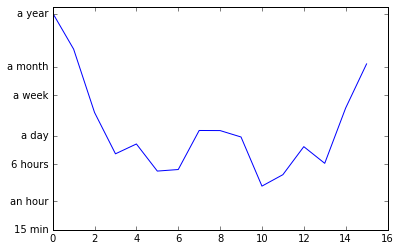

In [92]:
timebreaks = [-2.81, -1.43, 0.365, 1.75, 3.7, 5.08, 7.650835]
timelabels = ['15 min', 'an hour', '6 hours', 'a day', 'a week', 'a month', 'a year']

the18trend = np.sum(eighteenth, axis = 0) / len(eighteenth)
plt.plot(the18trend)
plt.yticks(timebreaks, timelabels)
plt.show()

#### uncertainty

How much of that trend can be relied on? Are the little bumps meaningful? Here's a quick and dirty way to ask the question: let's take five random bootstrap samples and plot them all.

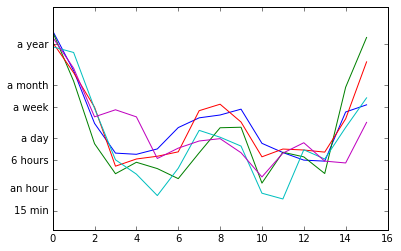

In [93]:
for i in range(5):
    randomsample = [random.choice(eighteenth) for x in eighteenth]
    sampletrend = np.sum(randomsample, axis = 0) / len(randomsample)
    plt.plot(sampletrend)
plt.yticks(timebreaks, timelabels)
plt.show()

**Quick and dirty answer:** no, the little bumps at the bottom of the curve are not meaningful. Only the overall arc.

Let's now superimpose the arcs for all three centuries. 18c at the top, 19c in the middle, 20c in red at the bottom.

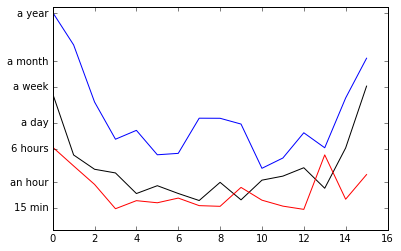

In [94]:
the19trend = np.sum(nineteenth, axis = 0) / len(nineteenth)
the20trend = np.sum(twentieth, axis = 0) / len(twentieth)
plt.plot(the18trend, c = 'b')
plt.plot(the19trend, c = 'k')
plt.plot(the20trend, c = 'r')
plt.yticks(timebreaks, timelabels)
plt.show()

It looks, from visual inspection, like the "bowl shape" of this trend gets much weaker in the twentieth century.

### Biography

The pattern in biography seems to be substantially different. It's not clear that there really is much of a trend, in fact.

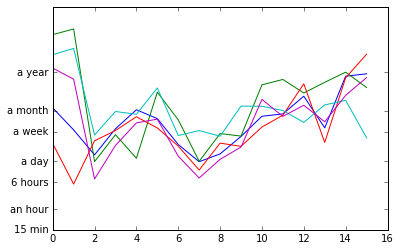

In [96]:
for i in range(5):
    randomsample = [random.choice(biography) for x in biography]
    sampletrend = np.sum(randomsample, axis = 0) / len(randomsample)
    plt.plot(sampletrend)
plt.yticks(timebreaks, timelabels)
plt.show()

### Specific books

Let's look at the difference between the pace of the first two + last two segments, and the pace of the middle. Books with a large number here cover much more time in their opening and closing 500 words than on average in the middle.

Books with a low or negative number are unusual in lacking, or reversing, the "bowl" shape.

In [62]:
tuplelist = []
for k, v in ratios.items():
    tuplelist.append((v, k))
tuplelist.sort()
tuplelist

[(-4.3823856012505127, 'Forever Amber'),
 (-3.7995753293345111,
  'FOUR ORIGINAL LETTERS VIZ. Two from a HUSBAND to a GENTLEMAN: AND Two from a HUSBAND to a WIFE.'),
 (-3.6332761139437659, 'The Godfather'),
 (-3.0946016980509068, 'Fairfax and his pride'),
 (-2.9329374904082295, "Tess of the D'Urbervilles"),
 (-2.6248066453771899, 'The Adventures of Tom Sawyer'),
 (-2.6198996059176216, 'Gone With the Wind'),
 (-2.390160460808807, 'Mrs Dalloway'),
 (-1.7583687559753669, 'The runaway jury'),
 (-1.7058364582697245, 'Asmodeus;'),
 (-1.6487222104755517, 'Frankenstein'),
 (-1.4822657654972291, 'Infinite Jest'),
 (-1.2017133164920395, 'The Mammoth Hunters'),
 (-1.1361607001435829, "Burger's daughter"),
 (-1.0116854634805639, 'The Age of Innocence'),
 (-0.99204904089786616, 'Court Netherleigh'),
 (-0.96904079241100582, 'East Lynne'),
 (-0.77728903414002881, 'Zoya'),
 (-0.6900173556456406, "Uncle Tom's Cabin"),
 (-0.68025635107928384, 'Seven keys to Baldpate'),
 (-0.65840014393051982, 'Lord of t

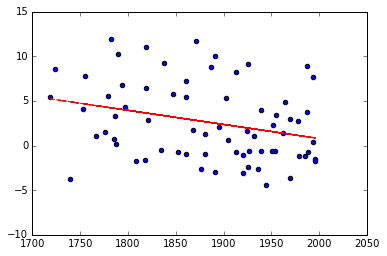

In [98]:
x = []
y = []
for title, ratio in ratios.items():
    y.append(ratio)
    x.append(dates[title])

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

In [75]:
stats.pearsonr(x, y)

(-0.28753524892097782, 0.016591318662407071)

### Interpretation

r = -0.29 and p = 0.017

That's not a terribly strong trend, but it is statistically significant. Effect size is medium. It's enough to discuss. The difference of pace between the ends and the middle goes down over time in a way that is clear, if not dramatic. It's also worth noting that the effect would probably be more dramatic if we stopped in the mid-20c. In that sense it may resemble the other historical curve we considered, which similarly bottomed out in mid-20c.

(-0.30593605391414114, 0.018449697265710295)


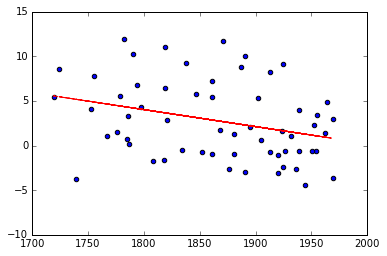

In [76]:
df = pd.DataFrame({'x': x, 'y': y})
df = df[df.x < 1975]

plt.scatter(df.x, df.y)
z = np.polyfit(df.x, df.y, 1)
p = np.poly1d(z)
plt.plot(df.x,p(df.x),"r--")
print(stats.pearsonr(df.x, df.y))